In [6]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib7 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

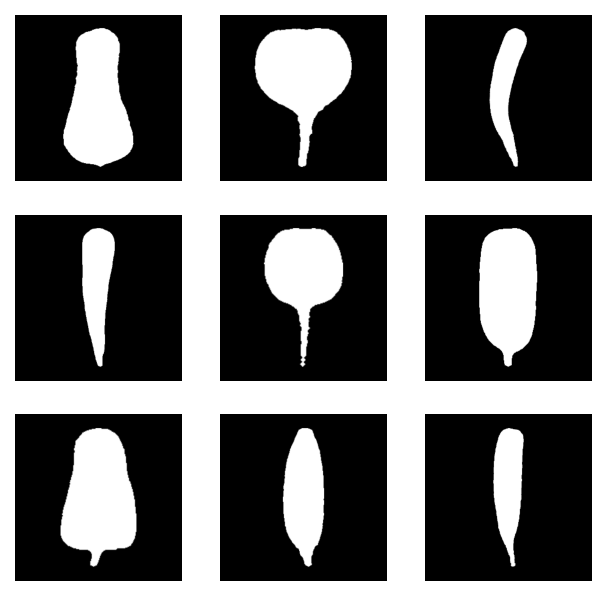

In [7]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [8]:
def fit0andDraw(imgnum,Nsamples=65,N=7):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func = bez.fit0(tpara=[])
    def meanerr(func, ts):
      sps = Samples
      fx, fy = func
      t = symbols('t')
      nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
      onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
      return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

    return func, meanerr(func,ts=bez.ts), Samples

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.5,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      func, err,Samples = fit0andDraw(imgnum,Nsamples=Nsamples,N=N)
      results[str(N)] = func
      if err < err_th:
        break
    print("\nN= {}  err = {}".format(N,err))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return func,results

def checkN(imgnum,mode=0,Nsamples=65,Nprolog=3,Nfrom=5,Nto=7,lr=0.005,lrP=400,preTry=100,maxTry=1500,pat=10,err_th=0.5, threstune=1.0):
    img = imgs[imgnum]
    config = wandb.config={
          'program':'checkN',
          ''
          'lr':lr,
          'maxTry':maxTry,
          'preTry':preTry,
          'pat':pat,
          'err_th':err_th}
    wandb.init(project="checkN %d" % imgnum,
                 config = config)
    rd.BezierCurve.wandb=wandb

    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')

    bez = rd.BezierCurve(N=0,samples=Samples) # インスタンス生成
    lastN,results = bez.fit2(mode=mode,Nprolog=Nprolog,Nfrom=Nfrom,Nto=Nto,pat=pat,lr=lr,lrP=lrP,err_th=err_th,preTry=preTry,maxTry=maxTry,withErr=True,threstune=threstune)
    cps,func,err = results[str(lastN)]
    rd.drawBez(img,stt=0.0,end=1.0,bezL=func,cntL=Samples)
    print("{:>3d}次でOK".format(lastN))
    return results

#from sympy import diff, Symbol, Matrix, symbols, solve, simplify, binomial, Abs, im, re, lambdify
import time
#from statistics import mean
def check1T(imgnum,test='smoothness_coe',mode=0,coe=0,Nsamples=65,N=7,optimizer_name='Adam',itt=3,lr=0.005,lrP=1000,maxTry=1500,pat=10,err_th=0.75,threstune=1.0,wandb=None,trial=None):
    start = time.time()
    if wandb:
      config = wandb.config={
          'program':'check1t',
          'mode':mode,
          'N':N,
          'optimizer_name':optimizer_name,
          test:coe,
          'mloop_itt':itt,
          'lr':lr,
          'lrP':lrP,
          'maxTry':maxTry,
          'pat':pat,
          'err_th':err_th}
      #調整するパラメータを登録
      wandb.init(project="keep-fit1t %d %d" % (imgnum,mode),
                 config = config)
      wandb.run.name = "%d-%5.2f"%(itt,lrP)
    rd.BezierCurve.wandb=wandb
    # rd.BezierCurve.eq_coe = coe
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    bestcps, bestfunc, minerror = bez.fit1T(maxTry=maxTry, mode=mode,optimizer_name=optimizer_name, lr=lr,lrP=lrP,withErr=True, tpara=[], pat=pat, err_th=err_th, threstune=threstune,trial=trial)
    rd.drawBez(img,stt=-0.00,end=1.00,bezL=bestfunc,cntL=Samples)
    elapsed_time = time.time() - start
    print(bestfunc)
    return minerror,elapsed_time


def twopass(imgnum,test='smoothness_coe',mode=0,coe=0,Nsamples=65,N=7,lr=0.005,lrP=1000,preTry=300,maxTry=1500,pat=10,err_th=0.75,threstune=1.0,wandb=None):
    start = time.time()
    if wandb:
      config = wandb.config={
          'program':'check1T0',
          'N':N,
          test:coe,
          'mloop_itt':itt,
          'lr':lr,
          'lrP':lrP,
          'maxTry':maxTry,
          'pat':pat,
          'err_th':err_th}
      #調整するパラメータを登録
      wandb.init(project="fit1T %d" % imgnum,
                 config = config,
                 reinit=True)
      wandb.run.name = "%d-%5.2f"%(itt,lrP)
    rd.BezierCurve.wandb=wandb
    # rd.BezierCurve.eq_coe = coe
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    # pass1
    preSamples = rd.getSamples(conAll,N=(Nsamples-1)//2+1,mode='Equidistant')
    prebez = rd.BezierCurve(N=N,samples=preSamples) # インスタンス生成
    print("Pass1")
    bestcps, prefunc, minerror = prebez.fit1T(maxTry=preTry, mode=mode, lr=lr,lrP=lrP,withErr=True, tpara=[], pat=pat, err_th=err_th, threstune=threstune)
    rd.drawBez(img,stt=0.00,end=1.00,bezL=prefunc,cntL=preSamples)
    print("Pass2",minerror)
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples,prefunc=prefunc) # インスタンス生成
    bestcps, bestfunc, minerror = bez.fit1T(maxTry=maxTry, mode=mode, lr=lr,lrP=lrP,withErr=True, pat=pat, err_th=err_th, threstune=threstune)
    rd.drawBez(img,stt=-0.00,end=1.00,bezL=bestfunc,cntL=Samples)
    elapsed_time = time.time() - start
    print(bestfunc)
    return minerror,elapsed_time

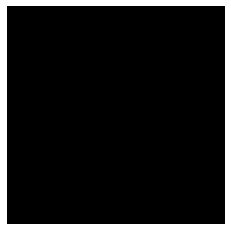

In [42]:
def plotimg(img, layout=111):
    if img.ndim == 2:
        pltgry(img, layout)
    elif img.ndim == 3:
        pltcol(img, layout)


def pltgry(img, layout=111):
    plt.subplot(layout)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))


def pltcol(img, layout=111):
    plt.subplot(layout)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plotimg(np.zeros([100,100,3],dtype=np.uint8))

[I 2021-05-31 17:29:28,519] A new study created in memory with name: no-name-bde42b4c-8963-44ba-9088-3801b034e22e


2021-05-31 17:29:28.522424
lrP: 1801.37


loss,8.0261
tloss,0.00043
sloss,5712.16699
_runtime,13
_timestamp,1622448954
_step,7


loss,█▆▄▃▃▂▂▁
tloss,█▇▇▆▃▃▂▁
sloss,▁▂▃▄▆███
_runtime,▁▁▂▄▄▅▇█
_timestamp,▁▁▂▄▄▅▇█
_step,▁▂▃▄▅▆▇█


....................................................................................................
.................................................................^^^.........................^^^^^^^
^^^^^^^^^^^^^.^...^.^.^^^^^^.^...^.^.^^^^^^.....^^^^^^.....^^^^..^^^^^^^^^^.....................^.^^

Matrix([[154.0*t**9 + 196.66*t**8*(9 - 9*t) + 2730.57*t**7*(1 - t)**2 + 19726.6*t**6*(1 - t)**3 + 94691.4*t**5*(1 - t)**4 - 43650.8*t**4*(1 - t)**5 - 2659.81*t**3*(1 - t)**6 + 8205.68*t**2*(1 - t)**7 + 1246.04*t*(1 - t)**8 + 148.0*(1 - t)**9], [280.0*t**9 + 100.311*t**8*(9 - 9*t) + 2070.36*t**7*(1 - t)**2 + 49436.6*t**6*(1 - t)**3 - 33267.3*t**5*(1 - t)**4 - 66265.7*t**4*(1 - t)**5 + 57098.1*t**3*(1 - t)**6 - 779.83*t**2*(1 - t)**7 + 1408.22*t*(1 - t)**8 + 279.0*(1 - t)**9]])
lrP:1.8013738566e+03,minerror: 3.0767893911, etime: 204.26075


loss,3.07726
tloss,0.00013
sloss,7321.51318
_runtime,200
_timestamp,1622449972
_step,299


loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▂▂▂
sloss,▁▁▂▃▄▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


[I 2021-05-31 17:32:56,357] Trial 0 finished with value: 3.0767893910638824 and parameters: {'lrP': 1801.3738566270147}. Best is trial 0 with value: 3.0767893910638824.


2021-05-31 17:32:56.357603
lrP: 1618.40


...............................

[I 2021-05-31 17:33:23,939] Trial 1 pruned. 


.Optuna による打ち切り
2021-05-31 17:33:23.939789
lrP: 1807.46


loss,4.01222
tloss,9e-05
sloss,6398.11572
_runtime,27
_timestamp,1622450003
_step,31


loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
tloss,█▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
_runtime,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


.......

[I 2021-05-31 17:33:39,908] Trial 2 pruned. 


.Optuna による打ち切り
2021-05-31 17:33:39.908611
lrP: 1644.25


loss,7.96316
tloss,0.0004
sloss,5720.46045
_runtime,12
_timestamp,1622450019
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▃▃▅▆▆██
_timestamp,▁▃▃▅▆▆██
_step,▁▂▃▄▅▆▇█


...............................

[I 2021-05-31 17:34:10,283] Trial 3 pruned. 


.Optuna による打ち切り
2021-05-31 17:34:10.284210
lrP: 1853.63


loss,4.00701
tloss,9e-05
sloss,6402.17871
_runtime,27
_timestamp,1622450050
_step,31


loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
tloss,█▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


.......

[I 2021-05-31 17:34:26,308] Trial 4 pruned. 


.Optuna による打ち切り
2021-05-31 17:34:26.309059
lrP: 1876.75


loss,7.96509
tloss,0.0004
sloss,5719.69873
_runtime,12
_timestamp,1622450066
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▄▄▅▇▇█
_timestamp,▁▂▄▄▅▇▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:34:43,643] Trial 5 pruned. 


.Optuna による打ち切り
2021-05-31 17:34:43.643551
lrP: 1615.72


loss,7.96625
tloss,0.00041
sloss,5719.32861
_runtime,12
_timestamp,1622450083
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▁▃▅▅▆██
_timestamp,▁▁▃▅▅▆██
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:34:58,798] Trial 6 pruned. 


.Optuna による打ち切り
2021-05-31 17:34:58.799529
lrP: 1859.65


loss,7.95982
tloss,0.0004
sloss,5723.71045
_runtime,11
_timestamp,1622450098
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▆▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▃▃▅▅▆██
_timestamp,▁▃▃▅▅▆██
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:35:14,020] Trial 7 pruned. 


.Optuna による打ち切り
2021-05-31 17:35:14.021332
lrP: 1777.82


loss,7.96538
tloss,0.0004
sloss,5719.60059
_runtime,12
_timestamp,1622450114
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▂▄▅▅▇█
_timestamp,▁▂▂▄▅▅▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:35:31,060] Trial 8 pruned. 


.Optuna による打ち切り
2021-05-31 17:35:31.061415
lrP: 1819.61


loss,7.96218
tloss,0.0004
sloss,5720.95557
_runtime,12
_timestamp,1622450131
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▂▄▅▅▇█
_timestamp,▁▂▂▄▅▅▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:35:46,278] Trial 9 pruned. 


.Optuna による打ち切り
2021-05-31 17:35:46.279206
lrP: 1702.78


loss,7.96365
tloss,0.0004
sloss,5720.25928
_runtime,12
_timestamp,1622450146
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▄▄▅▇▇█
_timestamp,▁▂▄▄▅▇▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:36:01,592] Trial 10 pruned. 


.Optuna による打ち切り
2021-05-31 17:36:01.593361
lrP: 1705.07


loss,7.9603
tloss,0.0004
sloss,5722.23779
_runtime,12
_timestamp,1622450161
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▁▃▅▅▆▆█
_timestamp,▁▁▃▅▅▆▆█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:36:16,853] Trial 11 pruned. 


.Optuna による打ち切り
2021-05-31 17:36:16.853786
lrP: 1673.74


loss,7.96037
tloss,0.0004
sloss,5722.19629
_runtime,11
_timestamp,1622450176
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▃▃▅▅▆██
_timestamp,▁▃▃▅▅▆██
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:36:32,248] Trial 12 pruned. 


.Optuna による打ち切り
2021-05-31 17:36:32.249498
lrP: 1755.78


loss,7.95994
tloss,0.0004
sloss,5722.73193
_runtime,12
_timestamp,1622450192
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▂▄▅▅▇█
_timestamp,▁▂▂▄▅▅▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:36:47,581] Trial 13 pruned. 


.Optuna による打ち切り
2021-05-31 17:36:47.582406
lrP: 1642.63


loss,7.96152
tloss,0.0004
sloss,5721.33105
_runtime,12
_timestamp,1622450207
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▁▃▅▅▆▆█
_timestamp,▁▁▃▅▅▆▆█
_step,▁▂▃▄▅▆▇█


...............................

[I 2021-05-31 17:37:18,117] Trial 14 pruned. 


.Optuna による打ち切り
2021-05-31 17:37:18.117795
lrP: 1725.53


loss,4.00734
tloss,9e-05
sloss,6401.92578
_runtime,27
_timestamp,1622450238
_step,31


loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
tloss,█▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


.......

[I 2021-05-31 17:37:33,133] Trial 15 pruned. 


.Optuna による打ち切り
2021-05-31 17:37:33.134139
lrP: 1789.02


loss,7.96079
tloss,0.0004
sloss,5721.84521
_runtime,12
_timestamp,1622450253
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▄▄▅▅▇█
_timestamp,▁▂▄▄▅▅▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:37:48,273] Trial 16 pruned. 


.Optuna による打ち切り
2021-05-31 17:37:48.273760
lrP: 1669.72


loss,7.96253
tloss,0.0004
sloss,5720.76758
_runtime,12
_timestamp,1622450268
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▂▄▄▅▇▇█
_timestamp,▁▂▄▄▅▇▇█
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:38:03,697] Trial 17 pruned. 


.Optuna による打ち切り
2021-05-31 17:38:03.697859
lrP: 1744.73


loss,7.95994
tloss,0.0004
sloss,5722.80078
_runtime,12
_timestamp,1622450283
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▁▃▅▅▆██
_timestamp,▁▁▃▅▅▆██
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:38:18,672] Trial 18 pruned. 


.Optuna による打ち切り
2021-05-31 17:38:18.673052
lrP: 1819.14


loss,7.96117
tloss,0.0004
sloss,5721.52051
_runtime,11
_timestamp,1622450298
_step,7


loss,█▅▄▃▃▂▂▁
tloss,█▇▇▅▃▂▂▁
sloss,▁▂▃▅▇███
_runtime,▁▁▃▅▅▆██
_timestamp,▁▁▃▅▅▆██
_step,▁▂▃▄▅▆▇█


.......

[I 2021-05-31 17:38:34,493] Trial 19 pruned. 


.Optuna による打ち切り
CPU times: user 6min 8s, sys: 1.76 s, total: 6min 9s
Wall time: 9min 5s


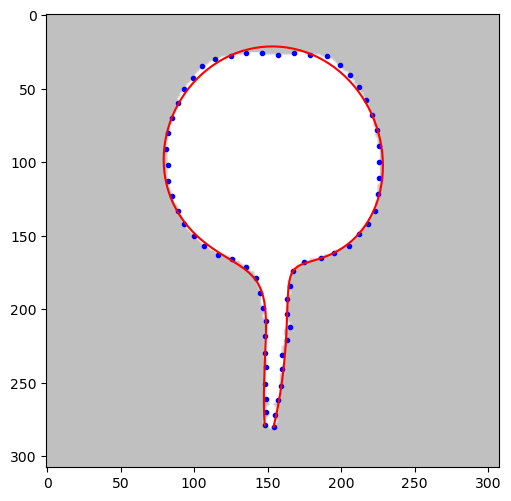

In [12]:
%%time
# SuccessiveHalvingPrunerの実験
# OptimizeAdam'
import tensorflow as tf
def objective(trial):
  print(datetime.datetime.now())
  lr = 0.0015
  obj = 'lrP'
  coe = lrP = trial.suggest_loguniform(obj, 1600,1900) # loguniform
  # coe = lrP = trial.suggest_float(obj, 812,2000,step=10) # loguniform
  print('%s: %4.2f' % (obj,coe)) 
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 1e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(4,mode=0,N=9,pat=500,maxTry=300,err_th=0.65,optimizer_name='Adam',itt=rd.BezierCurve.mloop_itt,lr=lr,lrP=lrP,test=obj,coe=lr,wandb=wandb,trial=trial)
  print('%s:%1.10e,minerror: %1.10f, etime: %3.5f' % (obj,coe, err, etime))
  wandb.finish()
  return err

# search_space = {"lrP": [1600,1650,1700]}
# study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))
# SuccessiveHavingPruner
pruner = optuna.pruners.SuccessiveHalvingPruner(        
        min_resource=2,
        reduction_factor=4,
        min_early_stopping_rate=1) 
study = optuna.study.create_study(pruner=pruner)
study.optimize(objective, n_trials=20, n_jobs=1)

In [ ]:
%%time
# OptimizeAdam'
import tensorflow as tf
def objective(trial):
  print(datetime.datetime.now())
  obj = 'lr'
  lr = 0.0015
  # coe = lr = trial.suggest_uniform(obj, 0.0013, 0.0016) # loguniform
  # lrP = 650 # 800　
  # coe = lr = trial.suggest_loguniform(obj, 0.01, 0.03) # loguniform
  coe = lrP = trial.suggest_uniform(obj, 1450,1700) # loguniform
  # optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Ftrl','SGD','Adagrad','RMSprop' ])
  #  lrP = 1
  print('%s: %1.10f' % (obj,coe)) 
  rd.BezierCurve.mloop_itt=20
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 1e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=500,maxTry=1000,err_th=0.65,optimizer_name='Adam',itt=rd.BezierCurve.mloop_itt,lr=lr,lrP=lrP,test=obj,coe=lr,wandb=wandb)
  print('%s:%1.10e,minerror: %1.10f, etime: %3.5f' % (obj,coe, err, etime))
  return err

study = optuna.create_study()
study.optimize(objective, n_trials=10, n_jobs=1)


# img 0 mloop_itt の違いによる収束の違い　まとめ

loss,3.08142
tloss,0.00015
sloss,12157.13574
_runtime,333
_timestamp,1622457534
_step,1543


loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁
tloss,▃█▆▅▅▄▃▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁
sloss,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^^^^^^^
^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

loss,3.08142
tloss,0.00015
sloss,12157.13574
_runtime,330
_timestamp,1622458741
_step,1543


loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁
tloss,▃█▆▅▅▄▃▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁
sloss,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................^^^^^.......^^^^^^^^^^..^^
^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^
^^^^......^^^^^^^^^^^^^......^^^^^^^^^^^^^^^...^^^^^^^^^^^^^^^.E

Matrix([[156.0*t**7 + 483.419*t**6*(7 - 7*t) - 11944.4*t**5*(1 - t)**2 + 50333.1*t**4*(1 - t)**3 - 38133.1*t**3*(1 - t)**4 + 17109.0*t**2*(1 - t)**5 - 1114.18*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 199.128*t**6*(7 - 7*t) - 303.474*t**5*(1 - t)**2 - 854.087*t**4*(1 - t)**3 + 2944.6*t**3*(1 - t)**4 - 1853.47*t**2*(1 - t

loss,0.6445
tloss,8e-05
sloss,11537.89258
_runtime,243
_timestamp,1622458988
_step,662


loss,█▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
tloss,▃█▆▅▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇██▇█▇██████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
.......^^^^.E

Matrix([[156.0*t**7 + 483.615*t**6*(7 - 7*t) - 11877.7*t**5*(1 - t)**2 + 50072.8*t**4*(1 - t)**3 - 37810.1*t**3*(1 - t)**4 + 17020.7*t**2*(1 - t)**5 - 1113.68*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 200.489*t**6*(7 - 7*t) - 104.88*t**5*(1 - t)**2 - 743.089*t**4*(1 - t)**3 + 2239.74*t**3*(1 - t)**4 - 1489.49*t**2*(1 - t)**5 + 1526.63*t*(1 - t)**6 + 279.0*(1 - t)**7]])


loss,0.64483
tloss,7e-05
sloss,11422.56348
_runtime,165
_timestamp,1622459157
_step,311


loss,█▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▂▆█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
.........................E

Matrix([[156.0*t**7 + 484.763*t**6*(7 - 7*t) - 11953.8*t**5*(1 - t)**2 + 50329.2*t**4*(1 - t)**3 - 38126.4*t**3*(1 - t)**4 + 17124.3*t**2*(1 - t)**5 - 1122.08*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 200.168*t**6*(7 - 7*t) - 30.0503*t**5*(1 - t)**2 - 894.241*t**4*(1 - t)**3 + 2255.31*t**3*(1 - t)**4 - 1423.1*t**2*(1 - t)**5 + 1525.69*t*(1 - t)**6 + 279.0*(1 - t)**7]])


loss,0.64964
tloss,7e-05
sloss,11457.17188
_runtime,264
_timestamp,1622459424
_step,324


loss,█▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▄█▆▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................................^..
..E

Matrix([[156.0*t**7 + 484.409*t**6*(7 - 7*t) - 11910.5*t**5*(1 - t)**2 + 50176.0*t**4*(1 - t)**3 - 37956.7*t**3*(1 - t)**4 + 17068.3*t**2*(1 - t)**5 - 1117.25*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 200.541*t**6*(7 - 7*t) - 12.073*t**5*(1 - t)**2 - 1060.75*t**4*(1 - t)**3 + 2480.15*t**3*(1 - t)**4 - 1529.07*t**2*(1 - t)**5 + 1537.68*t*(1 - t)**6 + 279.0*(1 - t)**7]])


loss,0.64702
tloss,7e-05
sloss,11421.12207
_runtime,606
_timestamp,1622460033
_step,401


loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▆█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▂▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
........................................^...................^..E

Matrix([[156.0*t**7 + 484.475*t**6*(7 - 7*t) - 11926.6*t**5*(1 - t)**2 + 50261.5*t**4*(1 - t)**3 - 38092.8*t**3*(1 - t)**4 + 17117.1*t**2*(1 - t)**5 - 1121.64*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 199.74*t**6*(7 - 7*t) + 23.5825*t**5*(1 - t)**2 - 1168.41*t**4*(1 - t)**3 + 2551.35*t**3*(1 - t)**4 - 1509.95*t**2*(1 - t)**5 + 1536.07*t*(1 - t)**6 + 279.0*(1 - t)**7]])


loss,0.64974
tloss,7e-05
sloss,11441.72266
_runtime,774
_timestamp,1622460810
_step,262


loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▆▇██▇▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


....................................................................................................
..............................................................................................^.....
.......................^....^..^...^..........E

Matrix([[156.0*t**7 + 484.555*t**6*(7 - 7*t) - 11916.4*t**5*(1 - t)**2 + 50222.4*t**4*(1 - t)**3 - 38083.7*t**3*(1 - t)**4 + 17114.4*t**2*(1 - t)**5 - 1121.03*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 199.052*t**6*(7 - 7*t) + 148.333*t**5*(1 - t)**2 - 1515.77*t**4*(1 - t)**3 + 2849.27*t**3*(1 - t)**4 - 1585.73*t**2*(1 - t)**5 + 1539.78*t*(1 - t)**6 + 279.0*(1 - t)**7]])


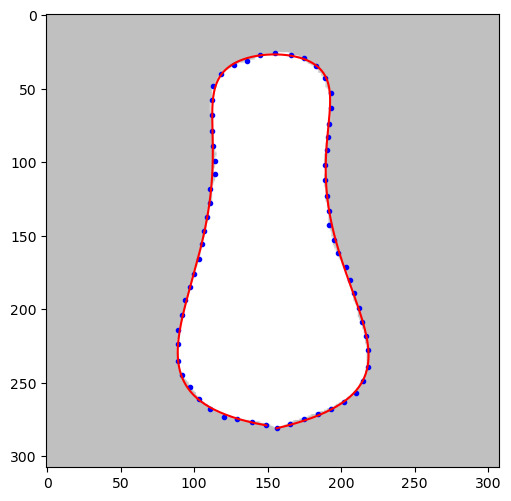

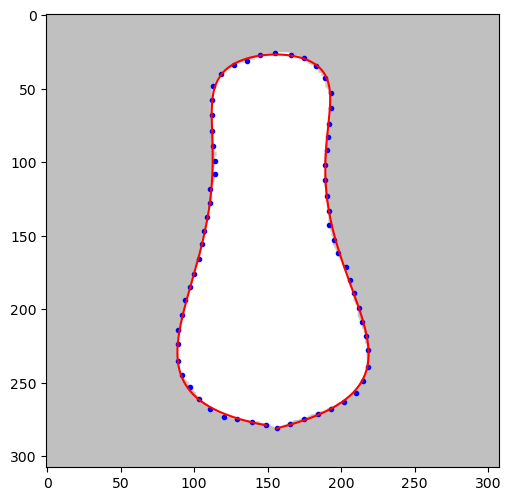

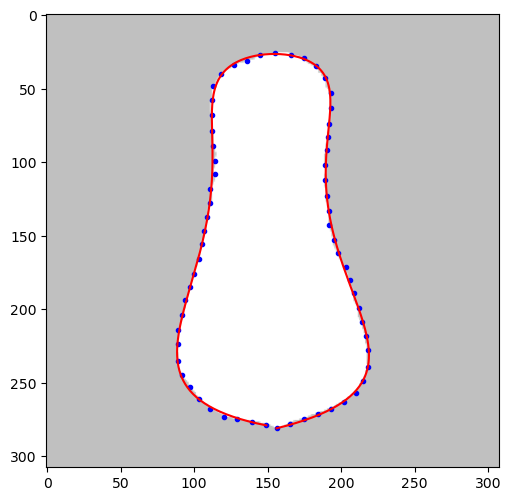

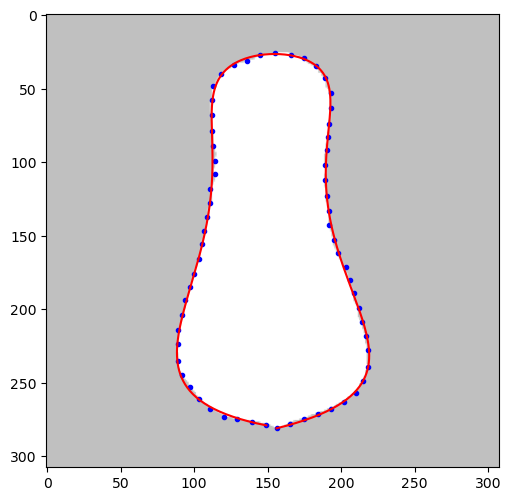

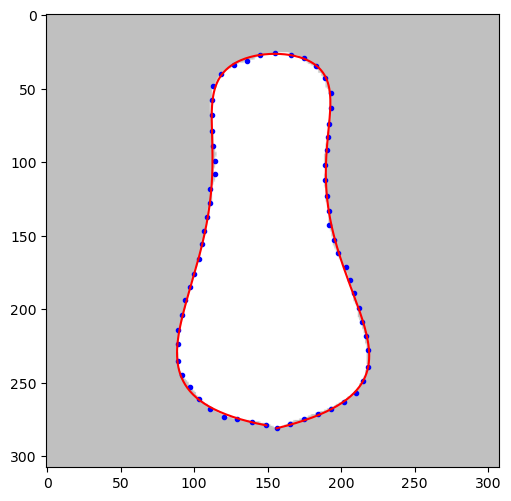

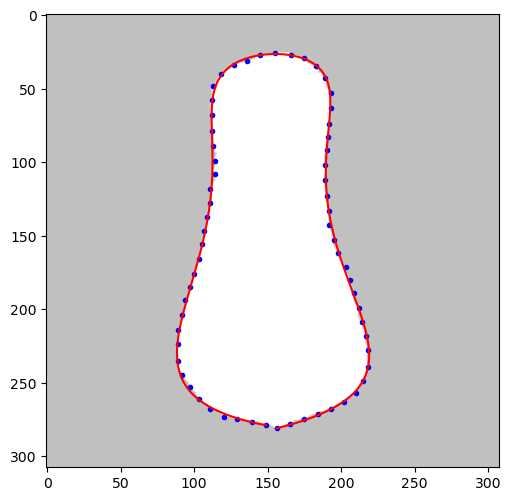

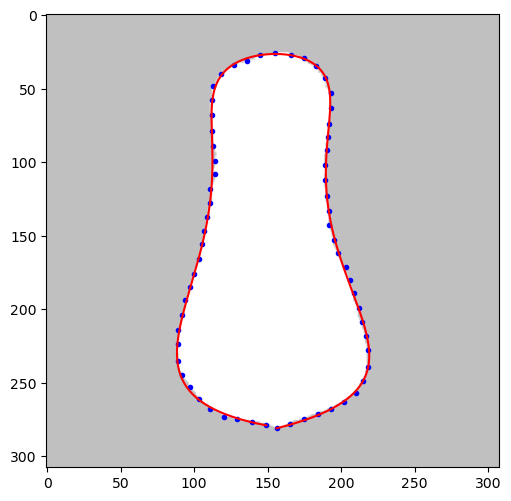

In [19]:
itts = [1,2,3,5,10,20,30]
lrPs = [770,800,1140,950,850,1600,1550]

lr = 0.0015
rd.BezierCurve.debugmode=False
rd.BezierCurve.convg_coe = 1e-5
rd.BezierCurve.swing_penalty  = 300
rd.BezierCurve.smoothness_coe = 4e-6

for itt,lrP in zip(itts,lrPs):
    rd.BezierCurve.mloop_itt=itt
    err,etime = check1T(0,mode=0,N=7,pat=500,maxTry=3000,err_th=0.65,optimizer_name='Adam',itt=itt,lr=lr,lrP=lrP,wandb=wandb)

loss,0.64839
tloss,7e-05
sloss,11434.50977
_runtime,1093
_timestamp,1622461907
_step,245


loss,█▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▂▇███▇▆▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^^^^^^^
^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

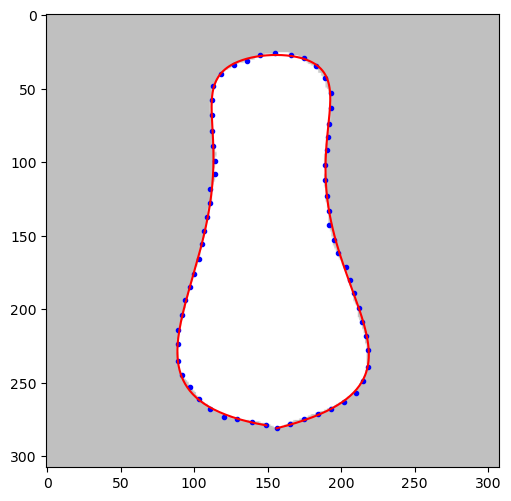

In [20]:
lr = 0.0015
rd.BezierCurve.debugmode=False
rd.BezierCurve.convg_coe = 1e-5
rd.BezierCurve.swing_penalty  = 300
rd.BezierCurve.smoothness_coe = 4e-6

rd.BezierCurve.mloop_itt=1
err,etime = check1T(0,mode=0,N=7,pat=3000,maxTry=3000,err_th=0.65,optimizer_name='Adam',itt=1,lr=lr,lrP=770,wandb=wandb)
print(err,etime)

# Adam の実ステップグラフ

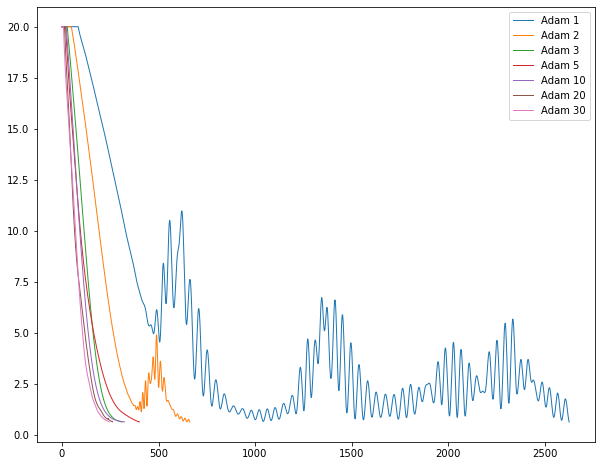

In [32]:
import matplotlib.pyplot
import numpy as np
import wandb

api = wandb.Api()
Adam30 = api.run("aquapathos/keep-fit1T 0 0/3ho62xh5").history(samples=3000) # Adam 30
Adam20 = api.run("aquapathos/keep-fit1T 0 0/3j1gw8sr").history(samples=3000) # Adam 20
Adam05 = api.run("aquapathos/keep-fit1T 0 0/3m844lhu").history(samples=3000) # Adam 10
Adam10 = api.run("aquapathos/keep-fit1T 0 0/3o0jvg4z").history(samples=3000) # Adam  5
Adam03 = api.run("aquapathos/keep-fit1T 0 0/2qy2t1ip").history(samples=3000) # Adam  3
Adam02 = api.run("aquapathos/keep-fit1T 0 0/2m3pciwd").history(samples=3000) # Adam  2
Adam01 = api.run("aquapathos/keep-fit1T 0 0/178vu4kb").history(samples=3000) # Adam  1

plt.figure(figsize=(10,8))
plt.plot(np.arange(len(Adam01['loss'])),Adam01['loss'].clip(upper=20),label="Adam 1",linewidth =1)
plt.plot(np.arange(len(Adam02['loss']))*1,Adam02['loss'].clip(upper=20),label="Adam 2",linewidth =1)
plt.plot(np.arange(len(Adam03['loss']))*1,Adam03['loss'].clip(upper=20),label="Adam 3",linewidth =1)
plt.plot(np.arange(len(Adam05['loss']))*1,Adam05['loss'].clip(upper=20),label="Adam 5",linewidth =1)
plt.plot(np.arange(len(Adam10['loss']))*1,Adam10['loss'].clip(upper=20),label="Adam 10",linewidth =1)
plt.plot(np.arange(len(Adam20['loss']))*1,Adam20['loss'].clip(upper=20),label="Adam 20",linewidth =1)
plt.plot(np.arange(len(Adam30['loss']))*1,Adam30['loss'].clip(upper=20),label="Adam 30",linewidth =1)
plt.legend()
plt.savefig("img.png")

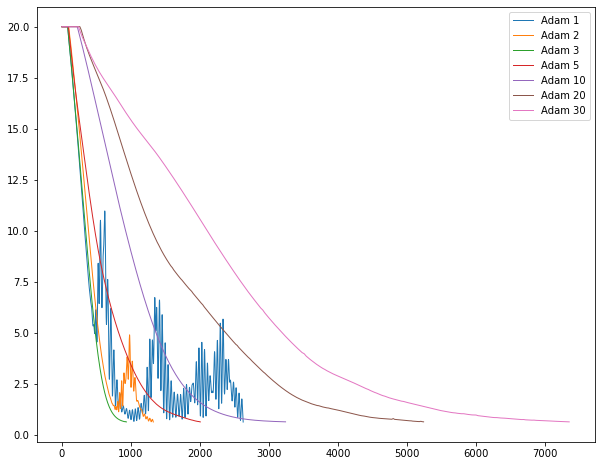

In [30]:
import matplotlib.pyplot
import numpy as np
import wandb

api = wandb.Api()
Adam30 = api.run("aquapathos/keep-fit1T 0 0/3ho62xh5").history(samples=3000) # Adam 30
Adam20 = api.run("aquapathos/keep-fit1T 0 0/3j1gw8sr").history(samples=3000) # Adam 20
Adam05 = api.run("aquapathos/keep-fit1T 0 0/3m844lhu").history(samples=3000) # Adam 10
Adam10 = api.run("aquapathos/keep-fit1T 0 0/3o0jvg4z").history(samples=3000) # Adam  5
Adam03 = api.run("aquapathos/keep-fit1T 0 0/2qy2t1ip").history(samples=3000) # Adam  3
Adam02 = api.run("aquapathos/keep-fit1T 0 0/2m3pciwd").history(samples=3000) # Adam  2
Adam01 = api.run("aquapathos/keep-fit1T 0 0/178vu4kb").history(samples=3000) # Adam  1

plt.figure(figsize=(10,8))
plt.plot(np.arange(len(Adam01['loss'])),Adam01['loss'].clip(upper=20),label="Adam 1",linewidth =1)
plt.plot(np.arange(len(Adam02['loss']))*2,Adam02['loss'].clip(upper=20),label="Adam 2",linewidth =1)
plt.plot(np.arange(len(Adam03['loss']))*3,Adam03['loss'].clip(upper=20),label="Adam 3",linewidth =1)
plt.plot(np.arange(len(Adam05['loss']))*5,Adam05['loss'].clip(upper=20),label="Adam 5",linewidth =1)
plt.plot(np.arange(len(Adam10['loss']))*10,Adam10['loss'].clip(upper=20),label="Adam 10",linewidth =1)
plt.plot(np.arange(len(Adam20['loss']))*20,Adam20['loss'].clip(upper=20),label="Adam 20",linewidth =1)
plt.plot(np.arange(len(Adam30['loss']))*30,Adam30['loss'].clip(upper=20),label="Adam 30",linewidth =1)
plt.legend()
plt.savefig("img2.png")

# Ftrl の実ステップグラフ

In [ ]:
import matplotlib.pyplot
import numpy as np
import wandb

api = wandb.Api()
ftrl30 = api.run("aquapathos/keep-fit1T 0 0/dmwvdjaz").history(samples=2000)　# Ftrl 30
ftrl20 = api.run("aquapathos/keep-fit1T 0 0/cbhtc21j").history(samples=2000)　# Ftrl 20
ftrl05 = api.run("aquapathos/keep-fit1T 0 0/ey21zjdp").history(samples=2000)　# Ftrl 10
ftrl10 = api.run("aquapathos/keep-fit1T 0 0/2peetehc").history(samples=2000)　# Ftrl 5
ftrl03 = api.run("aquapathos/keep-fit1T 0 0/6apxyycy").history(samples=2000)　# Ftrl 3
ftrl02 = api.run("aquapathos/keep-fit1T 0 0/2x6399me").history(samples=2000)　# Ftrl 2
ftrl01 = api.run("aquapathos/keep-fit1T 0 0/3o1nmpts").history(samples=2000)　# Ftrl 1

plt.figure(figsize=(10,8))
plt.plot(np.arange(len(ftrl01['loss'])),ftrl01['loss'].clip(upper=50),label="Ftrl 1",linewidth =1)
plt.plot(np.arange(len(ftrl02['loss']))*1,ftrl02['loss'].clip(upper=50),label="Ftrl 2",linewidth =1)
plt.plot(np.arange(len(ftrl03['loss']))*1,ftrl03['loss'].clip(upper=50),label="Ftrl 3",linewidth =1)
plt.plot(np.arange(len(ftrl05['loss']))*1,ftrl05['loss'].clip(upper=50),label="Ftrl 5",linewidth =1)
plt.plot(np.arange(len(ftrl10['loss']))*1,ftrl10['loss'].clip(upper=50),label="Ftrl 10",linewidth =1)
plt.plot(np.arange(len(ftrl20['loss']))*1,ftrl20['loss'].clip(upper=50),label="Ftrl 20",linewidth =1)
plt.plot(np.arange(len(ftrl30['loss']))*1,ftrl30['loss'].clip(upper=50),label="Ftrl 30",linewidth =1)
plt.legend()
plt.savefig("img.png")

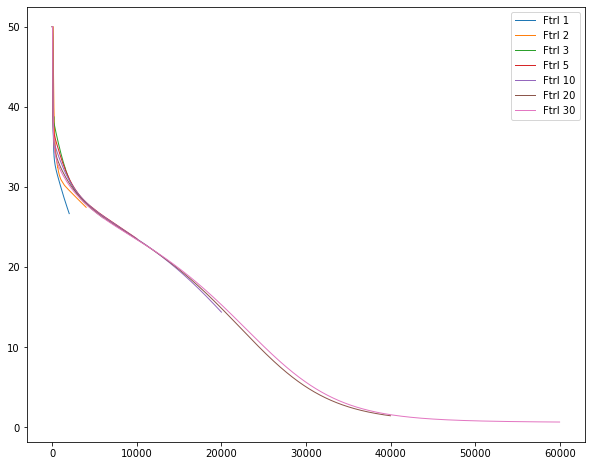

In [27]:
import matplotlib.pyplot
import numpy as np
import wandb

api = wandb.Api()
ftrl30 = api.run("aquapathos/keep-fit1T 0 0/dmwvdjaz").history(samples=2000)
ftrl20 = api.run("aquapathos/keep-fit1T 0 0/cbhtc21j").history(samples=2000)
ftrl05 = api.run("aquapathos/keep-fit1T 0 0/ey21zjdp").history(samples=2000)
ftrl10 = api.run("aquapathos/keep-fit1T 0 0/2peetehc").history(samples=2000)
ftrl03 = api.run("aquapathos/keep-fit1T 0 0/6apxyycy").history(samples=2000)
ftrl02 = api.run("aquapathos/keep-fit1T 0 0/2x6399me").history(samples=2000)
ftrl01 = api.run("aquapathos/keep-fit1T 0 0/3o1nmpts").history(samples=2000)

plt.figure(figsize=(10,8))
plt.plot(np.arange(len(ftrl01['loss'])),ftrl01['loss'].clip(upper=50),label="Ftrl 1",linewidth =1)
plt.plot(np.arange(len(ftrl02['loss']))*2,ftrl02['loss'].clip(upper=50),label="Ftrl 2",linewidth =1)
plt.plot(np.arange(len(ftrl03['loss']))*3,ftrl03['loss'].clip(upper=50),label="Ftrl 3",linewidth =1)
plt.plot(np.arange(len(ftrl05['loss']))*5,ftrl05['loss'].clip(upper=50),label="Ftrl 5",linewidth =1)
plt.plot(np.arange(len(ftrl10['loss']))*10,ftrl10['loss'].clip(upper=50),label="Ftrl 10",linewidth =1)
plt.plot(np.arange(len(ftrl20['loss']))*20,ftrl20['loss'].clip(upper=50),label="Ftrl 20",linewidth =1)
plt.plot(np.arange(len(ftrl30['loss']))*30,ftrl30['loss'].clip(upper=50),label="Ftrl 30",linewidth =1)
plt.legend()
plt.savefig("img2.png")

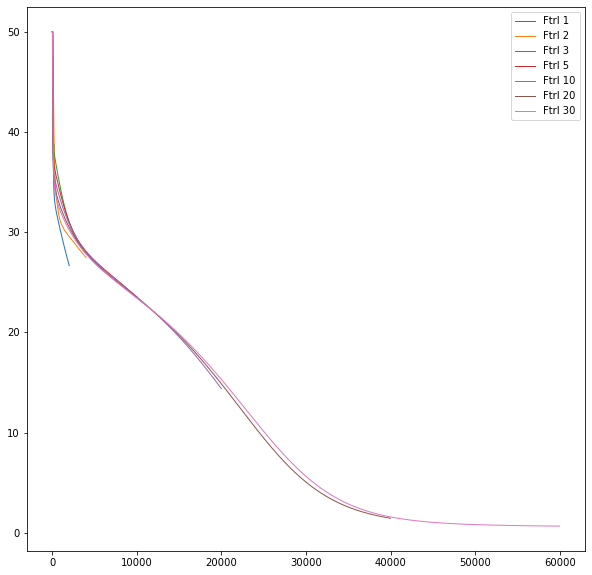

In [139]:
import matplotlib.pyplot
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(ftrl01['loss'])),ftrl01['loss'].clip(upper=50),label="Ftrl 1",linewidth =1)
plt.plot(np.arange(len(ftrl02['loss']))*2,ftrl02['loss'].clip(upper=50),label="Ftrl 2",linewidth =1)
plt.plot(np.arange(len(ftrl03['loss']))*3,ftrl03['loss'].clip(upper=50),label="Ftrl 3",linewidth =1)
plt.plot(np.arange(len(ftrl05['loss']))*5,ftrl05['loss'].clip(upper=50),label="Ftrl 5",linewidth =1)
plt.plot(np.arange(len(ftrl10['loss']))*10,ftrl10['loss'].clip(upper=50),label="Ftrl 10",linewidth =1)
plt.plot(np.arange(len(ftrl20['loss']))*20,ftrl20['loss'].clip(upper=50),label="Ftrl 20",linewidth =1)
plt.plot(np.arange(len(ftrl30['loss']))*30,ftrl30['loss'].clip(upper=50),label="Ftrl 30",linewidth =1)
plt.legend()
plt.savefig("img2.png")

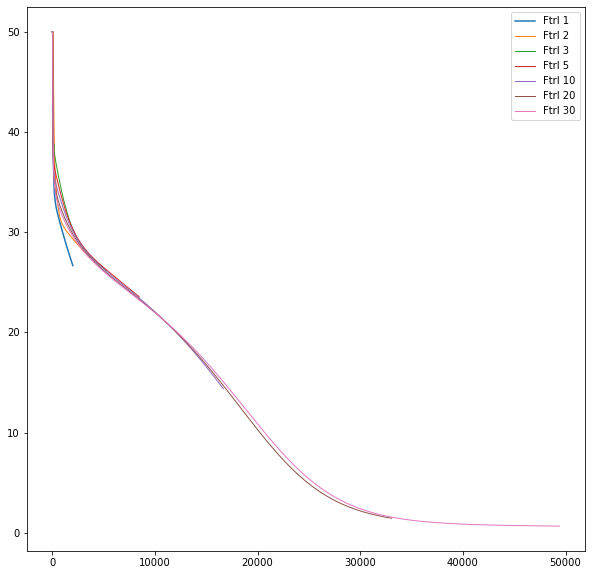

In [140]:
import matplotlib.pyplot
rtime = [417.15907,757.11568,1097,1768.11160,3475.97312,6897.00488,10312.71470]
r0 = rtime[0]
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(ftrl01['loss'])),ftrl01['loss'].clip(upper=50),label="Ftrl 1")
plt.plot(np.arange(len(ftrl02['loss']))*rtime[1]/r0,ftrl02['loss'].clip(upper=50),label="Ftrl 2",linewidth =1)
plt.plot(np.arange(len(ftrl03['loss']))*rtime[2]/r0,ftrl03['loss'].clip(upper=50),label="Ftrl 3",linewidth =1)
plt.plot(np.arange(len(ftrl05['loss']))*rtime[3]/r0,ftrl05['loss'].clip(upper=50),label="Ftrl 5",linewidth =1)
plt.plot(np.arange(len(ftrl10['loss']))*rtime[4]/r0,ftrl10['loss'].clip(upper=50),label="Ftrl 10",linewidth =1)
plt.plot(np.arange(len(ftrl20['loss']))*rtime[5]/r0,ftrl20['loss'].clip(upper=50),label="Ftrl 20",linewidth =1)
plt.plot(np.arange(len(ftrl30['loss']))*rtime[6]/r0,ftrl30['loss'].clip(upper=50),label="Ftrl 30",linewidth =1)
plt.legend()
plt.savefig("img3.png")

In [137]:
api = wandb.Api()
run30hist = api.run("aquapathos/keep-fit1T 0 0/dmwvdjaz").history(samples=2000)
run30hist

,_step,loss,_runtime,tloss,sloss,_timestamp
0,0,76.331919,13,0.000040,3983.870117,1621971979
1,1,54.620635,18,0.000053,3956.916748,1621971984
2,2,44.251470,23,0.000118,3919.957520,1621971989
3,3,39.770947,28,0.000211,3906.347168,1621971994
4,4,37.662259,33,0.000317,3903.040283,1621971999
...,...,...,...,...,...,...
1995,1995,0.669505,10289,0.000074,11421.746094,1621982255
1996,1996,0.669280,10294,0.000074,11422.289062,1621982260
1997,1997,0.669058,10300,0.000074,11422.819336,1621982266
1998,1998,0.668834,10305,0.000074,11423.351562,1621982271


loss,0.91074
tloss,6e-05
sloss,11214.35059
_runtime,154
_timestamp,1622180792
_step,299


loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▁▅█▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▂▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


....................................................................................................
....................................................................................................
....................................................................................................

Matrix([[156.0*t**7 + 427.834*t**6*(7 - 7*t) - 5994.11*t**5*(1 - t)**2 + 31620.8*t**4*(1 - t)**3 - 19025.0*t**3*(1 - t)**4 + 10753.0*t**2*(1 - t)**5 - 636.12*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 195.586*t**6*(7 - 7*t) + 4326.32*t**5*(1 - t)**2 - 5194.38*t**4*(1 - t)**3 - 2807.0*t**3*(1 - t)**4 + 2562.67*t**2*(1 - t)**5 + 1600.87*t*(1 - t)**6 + 279.0*(1 - t)**7]])
Adam minerror: 12.3978377316, etime: 157.17955


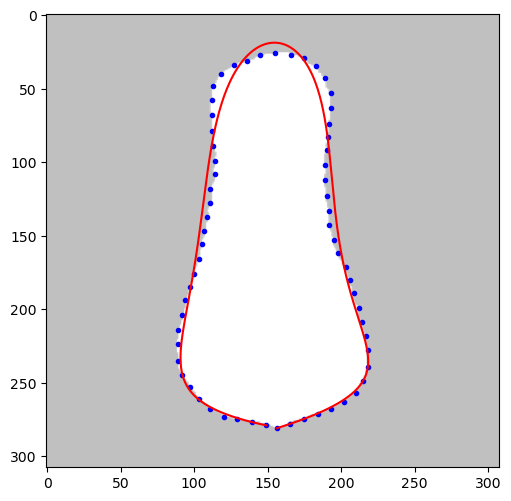

In [8]:

  optimizer_name='Adam' # HEREWEGO
  lr = 0.005
  lrP = 650
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 3e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=300,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))

In [ ]:
rd.BezierCurve.mloop_itt = 1
check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)

loss,0.66861
tloss,7e-05
sloss,11423.88867
_runtime,10310
_timestamp,1621982276
_step,1999


loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,██▇▇▇▇▆▆▆▅▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sloss,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


e36e2e2^e1e1^^.................................................^^^^^^^^........................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [16]:
rd.BezierCurve.mloop_itt = 1
err,etime = check1T(0,mode=0,N=7,pat=500,maxTry=3000,err_th=0.65,optimizer_name='Adam',itt=itt,lr=lr,lrP=770,wandb=wandb)

loss,18.02835
tloss,0.00048
sloss,6221.59961
_runtime,44
_timestamp,1622456421
_step,166


loss,█▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
tloss,▁▁▂▂▃▄▆▇▇███▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
sloss,▁▂▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^^^^^^^
^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt: 

In [ ]:
  optimizer_name='Nadam' # HEREWEGO
  lr = 0.001
  lrP = 500
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 3e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))

In [ ]:
  optimizer_name='AMSgrad' # HEREWEGO
  lr = 0.005
  lrP = 650
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 3e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))

In [ ]:
  optimizer_name='SGD' # HEREWEGO
  lr = 5e-6
  lrP = 2e6
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 3e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))

In [ ]:
  optimizer_name='Adamax' # HEREWEGO
  lr = 0.0075
  lrP = 1000
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 3e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_t = np.array([5.2, 5.7, 8.6, 14.9, 18.2, 20.4, 25.5, 26.4, 22.8, 17.5, 11.1, 6.6])
# jupyter notebookでグラフを表示するために必要
%matplotlib inline

# train_tをプロット
fig = plt.figure()
# 複数グラフを表示する場合に位置を指定する
# １枚だけ表示する場合は(1,1,1)で固定
subplot = fig.add_subplot(1,1,1)
# 表示するx軸の範囲
subplot.set_xlim(1,12)
# scatterメソッドで散布図を準備
# 第一引数がx軸の配列で、第二引数がそのペアとなるy軸の配列
# rangeは第二引数の一つ手前までの範囲なので、第二引数は13にしなければならない

import matplotlib.pyplot as plt

#plt.figure(1)                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot([1, 2, 3])
plt.subplot(212)             # the second subplot in the first figure
plt.plot([4, 5, 6])


#plt.figure(2)                # a second figure
plt.plot([4, 5, 6])          # creates a subplot(111) by default
'''
plt.figure(1)                # figure 1 current; subplot(212) still current
plt.subplot(211)             # make subplot(211) in figure1 current
plt.title('Easy as 1, 2, 3') # subplot 211 title''';

loss,13.45982
tloss,0.00022
sloss,6876.05322
_runtime,418
_timestamp,1622355385
_step,800


loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
tloss,▁▃▇█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃
sloss,▁▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


........................................^.....^.^.^.^^^.^.^^^...^^^^^..^.^^.....^.^^...^^^^...^.^^..

Matrix([[156.0*t**7 + 379.267*t**6*(7 - 7*t) - 2181.17*t**5*(1 - t)**2 + 21242.1*t**4*(1 - t)**3 - 9136.37*t**3*(1 - t)**4 + 7259.1*t**2*(1 - t)**5 - 312.677*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 211.384*t**6*(7 - 7*t) + 5791.33*t**5*(1 - t)**2 - 7244.45*t**4*(1 - t)**3 - 4555.87*t**3*(1 - t)**4 + 4250.65*t**2*(1 - t)**5 + 1688.67*t*(1 - t)**6 + 279.0*(1 - t)**7]])
RMSprop minerror: 21.2032527231, etime: 61.88381
CPU times: user 51.2 s, sys: 190 ms, total: 51.4 s
Wall time: 1min 1s


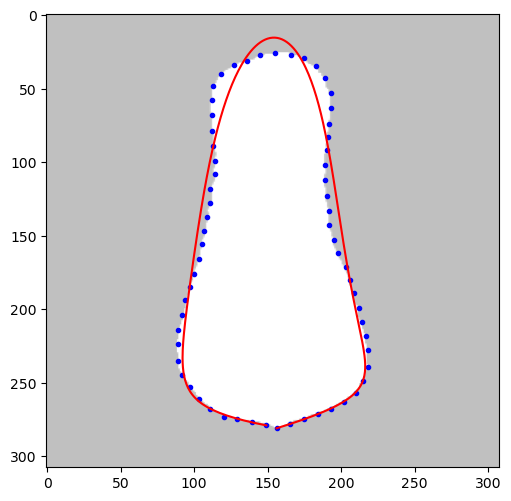

In [14]:
  %%time
  optimizer_name='RMSprop'
  lr =  0.0003
  lrP = 1300
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 1e-6
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=100,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))

In [ ]:
  optimizer_name='Adagrad'
  lr = 0.02
  lrP = 250
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 1e-6
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))


wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)


e6....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.........................................................................................

In [6]:
  optimizer_name='Adadelta'
  lr = 0.013
  lrP = 3500
  rd.BezierCurve.mloop_itt=3
  rd.BezierCurve.debugmode=False
  rd.BezierCurve.convg_coe = 3e-5
  rd.BezierCurve.swing_penalty  = 300
  rd.BezierCurve.smoothness_coe = 4e-6
  err,etime = check1T(0,mode=0,N=7,pat=2000,maxTry=2000,err_th=0.65,optimizer_name=optimizer_name,lr=lr,lrP=lrP,wandb=wandb)
  print('%s minerror: %1.10f, etime: %3.5f' % (optimizer_name, err, etime))


wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

KeyboardInterrupt: 

In [25]:
import wandb
api = wandb.Api()

# Change oreilly-class/cifar to <entity/project-name>
runs = api.runs("aquapathos/keep-fit1T 0 0")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in runs: 
    # run.summary are the output key/values like accuracy.  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.  We remove special values that start with _.
    config_list.append({k:v for k,v in run.config.items() if not k.startswith('_')}) 

    # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

all_df.to_csv("project.csv")

In [132]:
api.run("aquapathos/keep-fit1T 0 0/dmwvdjaz").history.__code__.co_varnames

('args', 'kwargs', 'message', 'err', 'payload')